In [26]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as  plt
%matplotlib inline

defenders = pd.read_csv(r'C:\Users\sosan\Documents\Dissertation\DataSets\Fifa 20\TransformedData\Defenders.csv')
defenders.head(5)

,Name,Image,Country,Position,Age,Overall,Potential,Club,ID,Height,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,Virgil van Dijk,https://cdn.sofifa.org/players/4/20/203376.png,Netherlands,CB,27,90,90,Liverpool,203376,193.0,...,Medium,Medium,3,77,60,70,71,90,86,425
1,Kalidou Koulibaly,https://cdn.sofifa.org/players/4/20/201024.png,Senegal,CB,28,89,89,Napoli,201024,188.0,...,Medium,High,3,71,28,54,67,89,87,303
2,Sergio Ramos García,https://cdn.sofifa.org/players/4/20/155862.png,Spain,CB,33,89,89,Real Madrid,155862,182.9,...,High,Medium,4,72,68,75,73,87,85,211
3,Giorgio Chiellini,https://cdn.sofifa.org/players/4/20/138956.png,Italy,CB,34,89,89,Juventus,138956,188.0,...,Medium,High,4,68,46,58,60,90,82,106
4,Diego Godín,https://cdn.sofifa.org/players/4/20/182493.png,Uruguay,CB,33,88,88,Inter,182493,188.0,...,Medium,High,3,60,48,64,61,89,83,103


In [27]:
defenders = defenders.drop(['Image','ID','A/W','D/W','Release Clause','Hits','Joined','Total Stats','Loan Date End', 'Release Clause','Position','Wage','Value','Name', 'BOV', 'Potential','Club'], axis = 1)

In [28]:
defenders.loc[defenders['BP'] == 'CB', 'BP'] = 0
defenders.loc[(defenders['BP'] == 'LB') | (defenders['BP'] == 'LWB'), 'BP'] = 1
defenders.loc[(defenders['BP'] == 'RB') | (defenders['BP'] == 'RWB'), 'BP'] = 2
defenders['BP'].head(10)

defenders.loc[defenders['foot'] == 'Right', 'foot'] = 1
defenders.loc[defenders['foot'] == 'Left', 'foot'] = 0

In [29]:
#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)
nat_counts = defenders.Country.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df):
    if (df.Country in nat_list):
        return 1
    else:
        return 0

#Create a copy of the original dataframe to avoid indexing errors
defenders1 = defenders.copy()

defenders1['Major_Nation'] = defenders1.apply(major_nation,axis = 1)

#Drop original columns used
defenders1 = defenders1.drop(['Country'], axis = 1)
defenders1.head()



,Age,Overall,Height,Weight,foot,BP,Growth,Attacking,Crossing,Finishing,...,W/F,SM,IR,PAC,SHO,PAS,DRI,DEF,PHY,Major_Nation
0,27,90,193.0,92.3,1,0,1,314,53,52,...,3,2,3,77,60,70,71,90,86,0
1,28,89,188.0,89.1,1,0,2,220,30,22,...,3,2,3,71,28,54,67,89,87,0
2,33,89,182.9,82.3,1,0,0,370,66,63,...,3,3,4,72,68,75,73,87,85,1
3,34,89,188.0,85.0,0,0,0,280,54,33,...,3,2,4,68,46,58,60,90,82,0
4,33,88,188.0,78.2,1,0,0,308,52,42,...,3,2,3,60,48,64,61,89,83,0


In [30]:
#Split ID as a Target value
target = defenders1.Overall
explanatory_var = defenders1.drop(['Overall'], axis = 1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(explanatory_var, target, test_size=0.2)

#One Hot Encoding
#x_train = pd.get_dummies(x_train)
#x_test = pd.get_dummies(x_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4923, 58) (4923,)
(1231, 58) (1231,)


In [31]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print(predictions[:10])
print(y_test[:10])
#Finding the r2 score and root mean squared error
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

[66.00675217 66.09946842 63.31848873 71.52754061 80.66965193 67.97580964
 71.28025086 67.22351298 62.56019906 66.00159236]
4101    64
2851    67
4224    63
902     73
136     80
3240    66
1338    71
2387    68
4642    62
3043    66
Name: Overall, dtype: int64
r2 score: 0.9704647972160688
RMSE : 1.0916620772451384


In [32]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.2164 ± 0.0120,Defending
0.0680 ± 0.0037,DRI
0.0398 ± 0.0022,Skill
0.0351 ± 0.0022,Interceptions
0.0318 ± 0.0036,Mentality
0.0187 ± 0.0030,Ball Control
0.0175 ± 0.0032,Crossing
0.0155 ± 0.0010,BP
0.0134 ± 0.0012,Vision
0.0128 ± 0.0019,PAS


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.inspection import permutation_importance

rf_reg_model = RandomForestRegressor(random_state=1, max_depth=10)
sgd_reg_model = SGDRegressor(random_state=1, max_iter=10)

rf_reg_model.fit(x_train, y_train)
sgd_reg_model.fit(x_train, y_train)

important_feat = rf_reg_model.feature_importances_

sgd_reg_model.fit(x_train, y_train)
# perform permutation importance
results = permutation_importance(sgd_reg_model, x_train, y_train, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean.argsort()

print(importance)

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

indices = np.argsort(important_feat)[-15:]  # top 10 features

print(indices)

[12 30  6 47 14 15 33  8 10 25 27 52 53  5 19 51 17 23 34  0 38 40 37 26
 41 31 35  1  9 20 43 46 48 49 55  3 50 57 42 45 44  4 32 11 21 56  2 39
 28 24 36 54 16 29 22  7 18 13]
Feature: 0, Score: 12.00000
Feature: 1, Score: 30.00000
Feature: 2, Score: 6.00000
Feature: 3, Score: 47.00000
Feature: 4, Score: 14.00000
Feature: 5, Score: 15.00000
Feature: 6, Score: 33.00000
Feature: 7, Score: 8.00000
Feature: 8, Score: 10.00000
Feature: 9, Score: 25.00000
Feature: 10, Score: 27.00000
Feature: 11, Score: 52.00000
Feature: 12, Score: 53.00000
Feature: 13, Score: 5.00000
Feature: 14, Score: 19.00000
Feature: 15, Score: 51.00000
Feature: 16, Score: 17.00000
Feature: 17, Score: 23.00000
Feature: 18, Score: 34.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 38.00000
Feature: 21, Score: 40.00000
Feature: 22, Score: 37.00000
Feature: 23, Score: 26.00000
Feature: 24, Score: 41.00000
Feature: 25, Score: 31.00000
Feature: 26, Score: 35.00000
Feature: 27, Score: 1.00000
Feature: 28, Score: 9.000

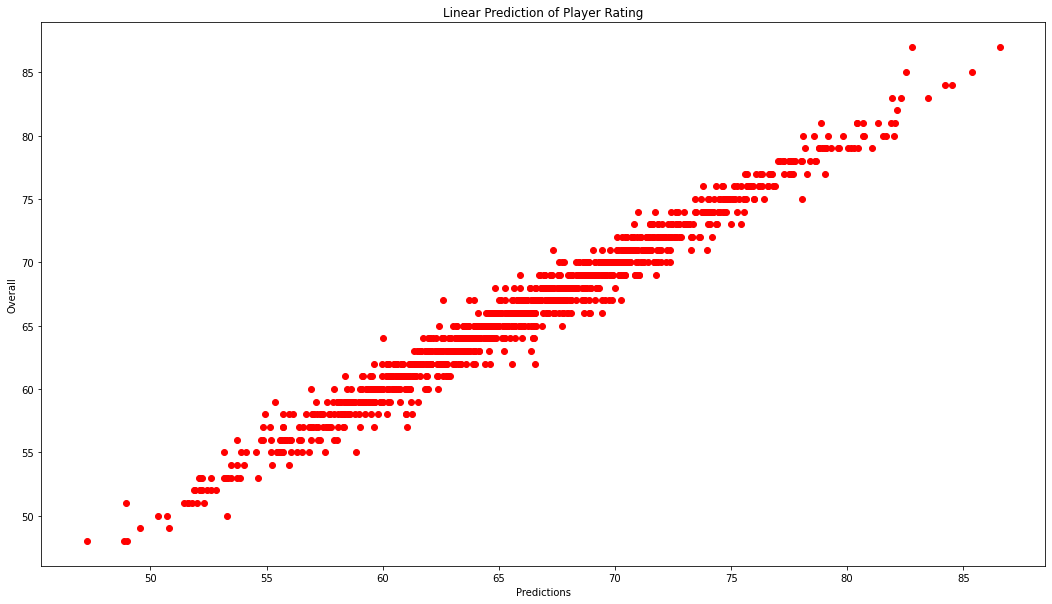

In [41]:
#import plotter
import seaborn as sns

import matplotlib.pyplot as  plt
%matplotlib inline

#Visualising the results
plt.figure(figsize=(18,10))
plt.scatter(predictions, y_test, color = "red")
#plt.plot(predictions, y_test, color = "green")
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()